In [1]:
# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
import scipy.stats as stats

from scipy.stats import shapiro, levene, mannwhitneyu
from scipy.stats import ttest_ind, norm, chi2_contingency

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer


Ejercicio
•	Fase 1: Exploración y Limpieza
1.	Exploración Inicial:
-   Realiza una exploración inicial de los datos para identificar posibles problemas, como valores nulos, atípicos o datos faltantes en las columnas   relevantes.
-   Utiliza funciones de Pandas para obtener información sobre la estructura de los datos, la presencia de valores nulos y estadísticas básicas de las columnas involucradas.
-   Une los dos conjuntos de datos de la forma más eficiente.

In [2]:
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

In [3]:
# cargamos todos los conjuntos de datos: 
dfa = pd.read_csv("Customer Flight Activity.csv", index_col = 0)
dfa.head(1)

,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
Loyalty Number,,,,,,,,,
100018,2017,1,3,0,3,1521,152.0,0,0


In [23]:
dlh = pd.read_csv("Customer Loyalty History.csv", index_col = 0)
dlh.head(1)

,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
Loyalty Number,,,,,,,,,,,,,,,
480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN


Revisamos el numero de filas y columnas para cada conjunto de datos y el detalle de sus columnas

In [26]:
dfa.shape

(405624, 9)

In [27]:
dlh.shape

(16737, 15)

In [28]:
dlh.columns

Index(['Country', 'Province', 'City', 'Postal Code', 'Gender', 'Education',
       'Salary', 'Marital Status', 'Loyalty Card', 'CLV', 'Enrollment Type',
       'Enrollment Year', 'Enrollment Month', 'Cancellation Year',
       'Cancellation Month'],
      dtype='object')

In [29]:
dfa.columns

Index(['Year', 'Month', 'Flights Booked', 'Flights with Companions',
       'Total Flights', 'Distance', 'Points Accumulated', 'Points Redeemed',
       'Dollar Cost Points Redeemed'],
      dtype='object')

In [30]:
# Fusionar los DataFrames mediante el índice 'Loyalty Number'
df= pd.merge(dlh, dfa, left_index=True, right_index=True)
df.columns

Index(['Country', 'Province', 'City', 'Postal Code', 'Gender', 'Education',
       'Salary', 'Marital Status', 'Loyalty Card', 'CLV', 'Enrollment Type',
       'Enrollment Year', 'Enrollment Month', 'Cancellation Year',
       'Cancellation Month', 'Year', 'Month', 'Flights Booked',
       'Flights with Companions', 'Total Flights', 'Distance',
       'Points Accumulated', 'Points Redeemed', 'Dollar Cost Points Redeemed'],
      dtype='object')

Iniciamos el analisis

In [31]:
# utilizamos reset_index para restablecer el índice del  DataFrame. Aplicamos inplace=True, asi los cambios se aplicarán directamente al DataFrame df 
df.reset_index(inplace=True)
df.head(1)

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.2,Standard,2016,8,NaN,NaN,2017,1,3,0,3,1521,152.0,0,0


In [33]:
# vision inicial de las tres primeras columnas
df.head(3)


,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.2,Standard,2016,8,NaN,NaN,2017,1,3,0,3,1521,152.0,0,0
1,100018,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.2,Standard,2016,8,NaN,NaN,2017,2,2,2,4,1320,132.0,0,0
2,100018,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.2,Standard,2016,8,NaN,NaN,2018,10,6,4,10,3110,311.0,385,31


In [34]:
# una vez que tengamos nuestro DataFrame preparado con todas las columnas que queremos vamos a crear una función que realice una exploración inicial del conjunto de datos
def eda(dataframe):
    """
    Realiza un análisis exploratorio básico de un DataFrame, mostrando información sobre duplicados,
    valores nulos, tipos de datos, valores únicos para columnas categóricas y estadísticas descriptivas
    para columnas categóricas y numéricas

    Parámetros:
    - dataframe (DataFrame): El DataFrame que se va a explorar.
    
    Returns: 
    No devuelve nada directamente, pero imprime en la consola la información exploratoria.
    """
    
    print(f"Los duplicados que tenemos en el conjunto de datos son: {dataframe.duplicated().sum()}")
    print("\n ..................... \n")
    
    print(f"el numero de filas y columnas del df son : {df.shape}")
    print("\n ..................... \n")
    
    # generamos un DataFrame para los valores nulos
    print("Los nulos que tenemos en el conjunto de datos son:")
    df_nulos = pd.DataFrame(dataframe.isnull().sum() / dataframe.shape[0] * 100, columns = ["%_nulos"])
    display(df_nulos[df_nulos["%_nulos"] > 0])
    
    # generamos un DataFrame para tipos de datos
    print("\n ..................... \n")
    print(f"Los tipos de las columnas son:")
    display(pd.DataFrame(dataframe.dtypes, columns = ["tipo_dato"]))

    # principales estadisticos de todas las columnas
    print("\n ..................... \n")

    # estadisticos columnas numericas
    print(f"estadisticos columnas numericas")
    display(df.describe().T)
    print("\n ..................... \n")

    # estadisticos columnas categoricas
    print(f"estadisticos columnas categoricas")
    display(df.describe(include = "O").T)
    
    print("\n ..................... \n")
    print("Los valores que tenemos para las columnas categóricas son: ")
    dataframe_categoricas = dataframe.select_dtypes(include = "O")
    
    for col in dataframe_categoricas.columns:
        print(f"La columna {col.upper()} tiene las siguientes valore únicos:")
        display(pd.DataFrame(dataframe[col].value_counts()).head())    
    


In [35]:
eda(df)

Los duplicados que tenemos en el conjunto de datos son: 1864

 ..................... 

el numero de filas y columnas del df son : (405624, 25)

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos
Salary,25.312112
Cancellation Year,87.657535
Cancellation Month,87.657535



 ..................... 

Los tipos de las columnas son:


,tipo_dato
Loyalty Number,int64
Country,object
Province,object
City,object
Postal Code,object
Gender,object
Education,object
Salary,float64
Marital Status,object
Loyalty Card,object



 ..................... 

estadisticos columnas numericas


,count,mean,std,min,25%,50%,75%,max
Loyalty Number,405624.0,550037.873084,258935.286969,100018.00,326961.00,550834.00,772194.00,999986.00
Salary,302952.0,79268.825953,34992.133508,-58486.00,59262.00,73479.00,88612.00,407228.00
CLV,405624.0,7991.976226,6863.663857,1898.01,3985.32,5776.34,8936.82,83325.38
Enrollment Year,405624.0,2015.252529,1.979427,2012.00,2014.00,2015.00,2017.00,2018.00
Enrollment Month,405624.0,6.668008,3.399766,1.00,4.00,7.00,10.00,12.00
Cancellation Year,50064.0,2016.499521,1.384336,2013.00,2016.00,2017.00,2018.00,2018.00
Cancellation Month,50064.0,6.966443,3.448300,1.00,4.00,7.00,10.00,12.00
Year,405624.0,2017.500000,0.500001,2017.00,2017.00,2017.50,2018.00,2018.00
Month,405624.0,6.500000,3.452057,1.00,3.75,6.50,9.25,12.00
Flights Booked,405624.0,4.115052,5.225518,0.00,0.00,1.00,8.00,21.00



 ..................... 

estadisticos columnas categoricas


,count,unique,top,freq
Country,405624,1,Canada,405624
Province,405624,11,Ontario,130896
City,405624,29,Toronto,81096
Postal Code,405624,55,V6E 3D9,21984
Gender,405624,2,Female,203640
Education,405624,5,Bachelor,253752
Marital Status,405624,3,Married,235800
Loyalty Card,405624,3,Star,184224
Enrollment Type,405624,2,Standard,382200



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna COUNTRY tiene las siguientes valore únicos:


,Country
Canada,405624


La columna PROVINCE tiene las siguientes valore únicos:


,Province
Ontario,130896
British Columbia,106848
Quebec,79968
Alberta,23400
Manitoba,15984


La columna CITY tiene las siguientes valore únicos:


,City
Toronto,81096
Vancouver,62520
Montreal,49920
Winnipeg,15984
Whistler,14040


La columna POSTAL CODE tiene las siguientes valore únicos:


,Postal Code
V6E 3D9,21984
V5R 1W3,16608
V6T 1Y8,14040
V6E 3Z3,13200
M2M 7K8,12936


La columna GENDER tiene las siguientes valore únicos:


,Gender
Female,203640
Male,201984


La columna EDUCATION tiene las siguientes valore únicos:


,Education
Bachelor,253752
College,102672
High School or Below,19008
Doctor,17856
Master,12336


La columna MARITAL STATUS tiene las siguientes valore únicos:


,Marital Status
Married,235800
Single,108648
Divorced,61176


La columna LOYALTY CARD tiene las siguientes valore únicos:


,Loyalty Card
Star,184224
Nova,137568
Aurora,83832


La columna ENROLLMENT TYPE tiene las siguientes valore únicos:


,Enrollment Type
Standard,382200
2018 Promotion,23424


In [36]:
# En una primera revisión encontramos  tres columnas con altos porcentajes de datos  nulos. Salary tiene valores negativos por lo que revisaremos esta columna con mas detalle. 
df_sorted = df.sort_values(by='Salary')
df_sorted['Salary']


23074    -58486.0
23085    -58486.0
23084    -58486.0
23083    -58486.0
23082    -58486.0
           ...   
405595        NaN
405596        NaN
405597        NaN
405598        NaN
405599        NaN
Name: Salary, Length: 405624, dtype: float64

De las observaciones iniciales, aquí están las acciones a tomar:
1.	Eliminar la columna "country": todos los valores de esta columna son "Canada", puede informarse que los datos son de canada sin incluirlo en el dataFrame.
2.	Revisar la columna "salary": tiene un alto porcentaje de valores negativos y nulos, es importante investigar más a fondo que hacer éstos valores. Es decir dependiendo del análisis a realizar tomaremos decisiones,
3.	Tratar las columnas "cancellation_year" y "cancellation_month": 
Tienen un alto porcentaje de valores nulos, se pueden considerar utilizar técnicas avanzadas de imputación para mantener la información que potencialmente podría ser útil para problemas específicos de la empresa.
4.	Modificar los tipos de datos: Para las columnas donde se pueden realizar operaciones numéricas,  es necesario convertir los datos a tipo float si aún no lo están. 
5. Unificaremos los string tanto columnas como valores a minusculas y en los espacios guion bajo.


# Cleaning

In [37]:
# vamos a cambiar el formato de las columnas, utilizando una list_comprension. for col in df.columns: Itera sobre cada columna en el DataFrame df y realiza lo siguiente:
# col.lower(): Convierte el nombre de la columna a minúsculas.
# .replace(" ", "_"): Reemplaza cualquier espacio en blanco en el nombre de la columna con un guion bajo "_".
columnas = [col.lower().replace(" ", "_") for col in df.columns]
df.columns = columnas
df.head(2)

,loyalty_number,country,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
0,100018,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.2,Standard,2016,8,NaN,NaN,2017,1,3,0,3,1521,152.0,0,0
1,100018,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.2,Standard,2016,8,NaN,NaN,2017,2,2,2,4,1320,132.0,0,0


In [38]:
def clean_column(column):
    """
    Convierte los valores de una columna a minúsculas y reemplaza los espacios con '_'.
    
    Parámetros:
    - columna: La columna que se desea limpiar.
    
    Retorna:
    - La columna limpia.
    """
    # Convertir a minúsculas y reemplazar espacios con '_'
    column = column.str.lower().str.replace(' ', '_')
    return column

In [39]:
# borramos la country
df.drop(['country'], axis=1, inplace=True)

In [40]:
# Lista de columnas que deseas limpiar
clean_C = ['province', 'city', 'postal_code', 'gender', 'education', 'marital_status', 'loyalty_card', "enrollment_type"]

In [41]:
# Aplicar la función a las columnas seleccionadas, mediante el metodo apply que puede usarse tanto para filas como para columnas
df[clean_C] = df[clean_C].apply(clean_column)

In [42]:
df.head(2)

,loyalty_number,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
0,100018,alberta,edmonton,t9g_1w3,female,bachelor,92552.0,married,aurora,7919.2,standard,2016,8,NaN,NaN,2017,1,3,0,3,1521,152.0,0,0
1,100018,alberta,edmonton,t9g_1w3,female,bachelor,92552.0,married,aurora,7919.2,standard,2016,8,NaN,NaN,2017,2,2,2,4,1320,132.0,0,0


In [47]:
# Creamos una lista con las columnas que queremos convertir a float
to_float = ['dollar_cost_points_redeemed', 'distance', 'points_redeemed', "enrollment_year"]

In [48]:
def convert_data_type(df, columns):
    """
    Esta función convierte las columnas especificadas del DataFrame df en tipo de datos float.
    
    Args:
    - df: DataFrame pandas que contiene las columnas a ser convertidas.
    - columnas: Lista de nombres de columnas que se convertirán en tipo de datos float.
    
    Returns:
    - df: DataFrame pandas con las columnas especificadas convertidas en tipo de datos float.
    """
    for column in columns:
        df[column] = df[column].astype(float)
    return df

In [45]:
#aplicamos la funcion
df = convert_data_type(df, to_float)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loyalty_number               405624 non-null  int64  
 1   province                     405624 non-null  object 
 2   city                         405624 non-null  object 
 3   postal_code                  405624 non-null  object 
 4   gender                       405624 non-null  object 
 5   education                    405624 non-null  object 
 6   salary                       302952 non-null  float64
 7   marital_status               405624 non-null  object 
 8   loyalty_card                 405624 non-null  object 
 9   clv                          405624 non-null  float64
 10  enrollment_type              405624 non-null  object 
 11  enrollment_year              405624 non-null  int64  
 12  enrollment_month             405624 non-null  int64  
 13 

In [50]:
#  la columna salarios tiene valores negativos calculamos el porcentaje de negativos.
negatives_count = df[df['salary'] < 0]['salary'].count()
porc_negatives_count = negatives_count/df.shape[0]*100
porc_negatives_count

0.11833619312466717

In [67]:
# creamos un filtro y contamos los negativos
negatives_count = df[df['salary'] < 0]['salary'].count()
negatives_count

480

In [51]:
# consideramos que el salario se ha introducido por error con signo negativo asi que lo corregimos.
df["salary"] = abs(df["salary"])

In [36]:
# revisamos los valores modificados
df["salary"].describe()

count    302952.000000
mean      79381.440228
std       34735.904533
min        9081.000000
25%       59262.000000
50%       73479.000000
75%       88612.000000
max      407228.000000
Name: salary, dtype: float64

In [89]:
# borramos duplicados son el 0.46% de los datos 
df.drop_duplicates(inplace=True)

In [72]:
# Revisamos filas columnas
df.shape

(403760, 24)

In [52]:
col_num_nul =[ "cancellation_month","salary", "cancellation_year", ]

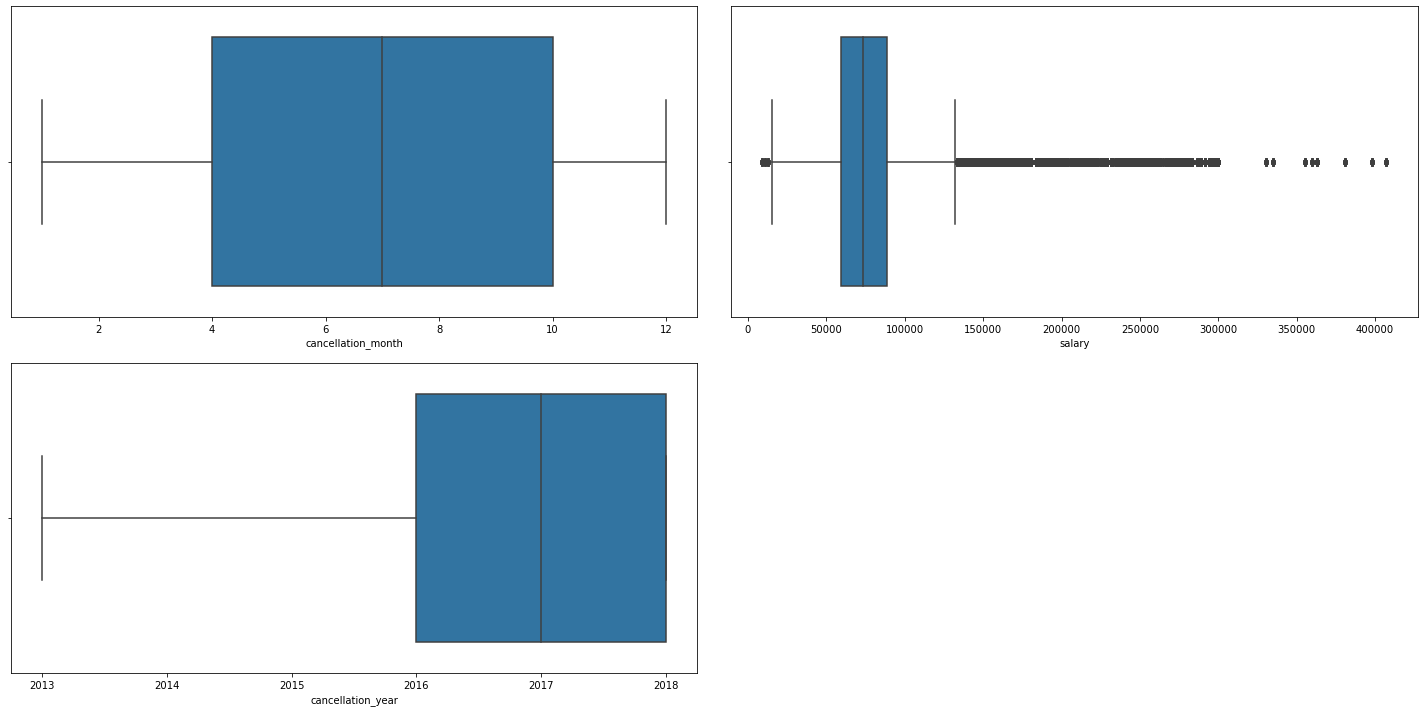

In [53]:
# lo siguiente que tendríamos que hacer es ver si dentro de las columnas donde tenemos nulos tenemos valores atípicos. 

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20,10)) 

axes = axes.flat

for indice, col in enumerate(col_num_nul):
    sns.boxplot(x = col, data = df, ax = axes[indice])
    
plt.tight_layout()
fig.delaxes(axes[-1]);


Observamos valores atípicos en la columna salary y continuaremos investigando sus valores. Además, observamos que las columnas "cancellation_year" y "cancellation_month" tienen el mismo porcentaje de valores nulos. Dado el contexto, estas últimas podrían corresponder a la cancelación de tarjetas de fidelidad del cliente, mientras que las columnas sin valores podrían representar las tarjetas activas. Siguiendo este criterio, podemos imputar los valores desconocidos como tarjetas activas. Alternativamente, podríamos crear una nueva columna para indicar explícitamente los clientes activos y dejar las columnas originales como están. Por ahora, realizaremos los cambios directamente en las columnas existentes.

Tomar esta decisión para un porcentaje tan elevado de valores desconocidos se ha basado en el contenido de la columna y en el comportamiento observado. La distribución de cancelaciones parece seguir el principio 80/20 de Pareto, aunque no podemos confirmarlo sin un análisis más detallado. Sin embargo, esta observación sugiere que un porcentaje relativamente pequeño de tarjetas se cancelan, mientras que la mayoría permanecen activas, lo que podría reflejar una relación desigual similar a la propuesta por la ley de Pareto.
Las tarjetas han sido canceladas entre los meses 4-10 y los años 2016-2018. Podemos consultar con el cliente esta decisión.

Imputar los datos de las columnas: cancellation_year', 'cancellation_month' los reemplazamos por uncancelled

In [54]:
# Aplicamos la transformación con una función lambda usando apply
df[['cancellation_month', 'cancellation_year']] = df[['cancellation_month', 'cancellation_year']].apply(lambda col: col.fillna('uncancelled'))

In [21]:
df['cancellation_year'].isnull().sum() / df.shape[0]

0.0

In [55]:
df['cancellation_month'].isnull().sum() / df.shape[0]

0.0

Fase 2: Visualización: 
Usando las herramientas de visualización que has aprendido durante este módulo, contesta a las siguientes gráficas usando la mejor gráfica que consideres:


1. ¿Cómo se distribuye la cantidad de vuelos reservados por mes durante el año?

In [56]:
# Agrupar los datos por año y mes, y sumar la cantidad de vuelos reservados en cada grupo
vuelos_por_anio_mes = df.groupby(['year', 'month'])['flights_booked'].sum()
# Crear un nuevo DataFrame con los resultados
vuelos_df = vuelos_por_anio_mes.reset_index()
vuelos_df

,year,month,flights_booked
0,2017,1,47766
1,2017,2,47691
2,2017,3,64271
3,2017,4,55720
4,2017,5,65279
5,2017,6,80493
6,2017,7,89288
7,2017,8,78692
8,2017,9,63304
9,2017,10,60351


In [57]:
# Filtrar el DataFrame original para el año 2017
df_2017 = df[df['year'] == 2017]

# Calcular la suma de vuelos reservados por mes para el año 2017
vuelos_por_mes_2017 = df_2017.groupby('month')['flights_booked'].sum()

# Crear un nuevo DataFrame para el año 2017
df_2017_resultado = vuelos_por_mes_2017.reset_index()
print("\nDataFrame para el año 2017:")
df_2017_resultado


DataFrame para el año 2017:


,month,flights_booked
0,1,47766
1,2,47691
2,3,64271
3,4,55720
4,5,65279
5,6,80493
6,7,89288
7,8,78692
8,9,63304
9,10,60351


In [58]:

# Filtrar el DataFrame original para el año 2018
df_2018 = df[df['year'] == 2018]
# Calcular la suma de vuelos reservados por mes para el año 2018
vuelos_por_mes_2018 = df_2018.groupby('month')['flights_booked'].sum()
# Crear un nuevo DataFrame para el año 2018
df_2018_resultado = vuelos_por_mes_2018.reset_index()
# Mostrar los resultados
print("\nDataFrame para el año 2018:")
df_2018_resultado


DataFrame para el año 2018:


,month,flights_booked
0,1,49170
1,2,48643
2,3,66928
3,4,56791
4,5,76891
5,6,92749
6,7,104143
7,8,90512
8,9,73075
9,10,69110


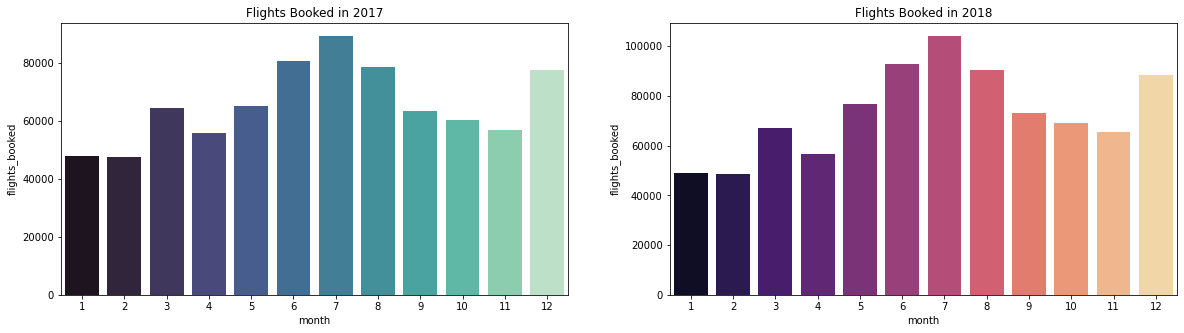

In [59]:
# Establecemos nuestra gráfica con un subplots  indicando el número de filas y columnas que queremos, lo que equivale a la matriz de espacios para crear graficas.
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Con Seaborn  usaremos el parámetro 'ax' indicamos la posición de la grafica

sns.barplot(x = "month",
            y = "flights_booked", 
            data = df_2017_resultado, 
            ax = axes[0], 
            palette= "mako")
axes[0].set_title('Flights Booked in 2017')

# hacemos lo mismo para el violinplot
sns.barplot(x = "month", 
               y = "flights_booked", 
               data = df_2018_resultado, 
               ax = axes[1], 
               palette = "magma")
axes[1].set_title('Flights Booked in 2018');

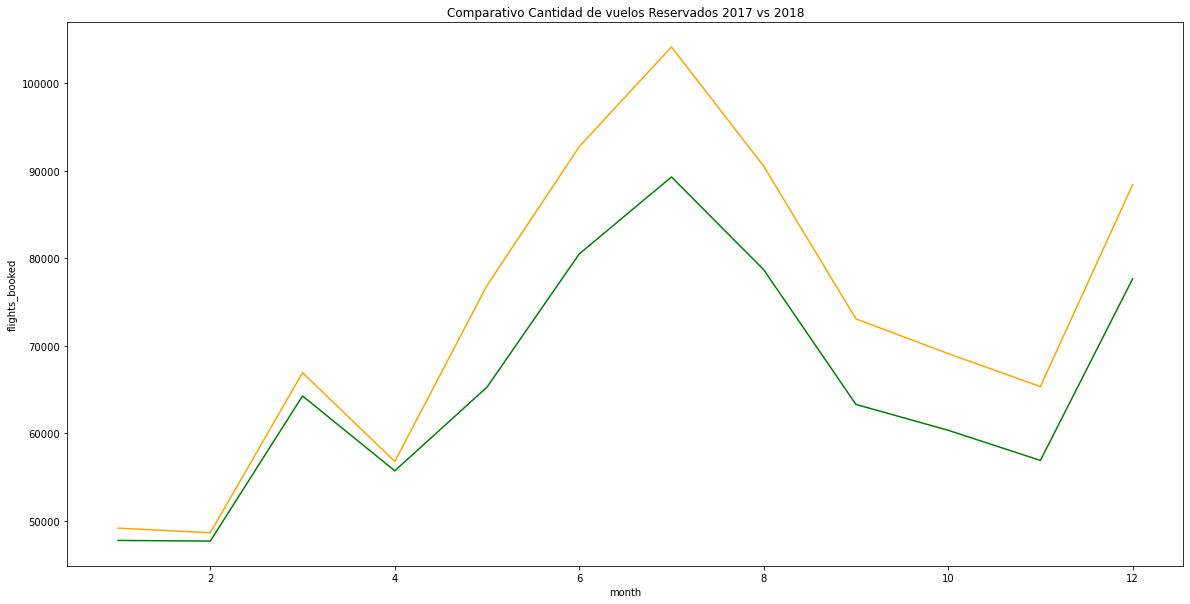

In [61]:
# Este código utiliza las bibliotecas Matplotlib y Seaborn para crear un gráfico de líneas que compara el número de vuelos reservados en dos años diferentes (2017 y 2018).
plt.figure(figsize=(20, 10))
sns.lineplot(x=df_2017_resultado["month"], y=df_2017_resultado["flights_booked"], color = "green")
sns.lineplot(x=df_2018_resultado["month"], y=df_2018_resultado["flights_booked"], color = "orange")
plt.title('Comparativo Cantidad de vuelos Reservados 2017 vs 2018');


Se observan incrementos significativos en la cantidad de vuelos reservados durante los períodos vacacionales de mitad y final de año. Es importante destacar que el comportamiento de los vuelos por año muestra una tendencia similar, lo que sugiere una estacionalidad consistente en la demanda de vuelos a lo largo del tiempo. Sin embargo, para el año 2018, se observa un crecimiento en el número de vuelos  a partir del 4 mes en comparación con el año anterior. Para obtener un análisis más detallado, sería útil trazar una gráfica que indique el crecimiento porcentual a lo largo de los años, lo cual podríamos realizar en los next step de nuestro análisis.

2. ¿Existe una relación entre la distancia de los vuelos y los puntos acumulados por los clientes?

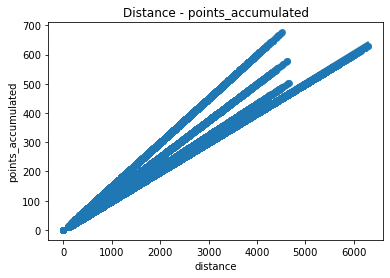

In [78]:
# Es una gráfica que se utiliza para trazar un gráfico de dispersión (*scatter plot*) junto con una línea de regresión lineal que se ajusta a los datos. Esta línea de regresión lineal muestra la tendencia general de la relación entre dos variables y puede ayudar a identificar patrones o tendencias en los datos. 
# visualizamoms la relacion entre las columnas distance y points_accumulated. Analizamos para el df de inicio
sns.regplot(x = 'distance', 
y = 'points_accumulated', 
data = df)
plt.xlabel('distance')
plt.ylabel('points_accumulated')
plt.title("Distance - points_accumulated");

En este primer gráfico, parece que hay líneas adicionales que podrían indicar otra categoría, como los años. Para explorar esto con más detalle, hemos decidido graficar cada año por separado utilizando el mismo tipo de gráfico.

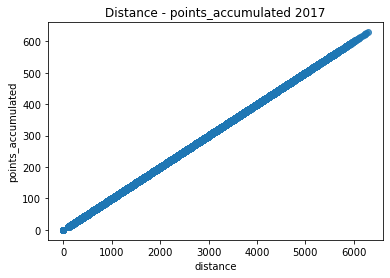

In [85]:
# Graficamos con df para el año 2017
sns.regplot(x = 'distance', 
y = 'points_accumulated', 
data = df_2017)
plt.xlabel('distance')
plt.ylabel('points_accumulated')
plt.title("Distance - points_accumulated 2017");

 Para el año 2017 observamos una linea sin outliers  o puntos que se desvíen significativamente de la línea de regresión, esto significaría que, en general, a medida que la distancia de los vuelos aumenta, los puntos acumulados también aumentan de manera constante.

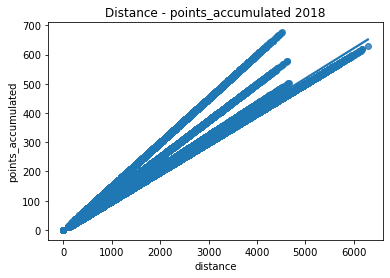

In [86]:
# Graficamos para el año 2018
sns.regplot(x = 'distance', 
y = 'points_accumulated', 
data = df_2018)
plt.xlabel('distance')
plt.ylabel('points_accumulated')
plt.title("Distance - points_accumulated 2018");

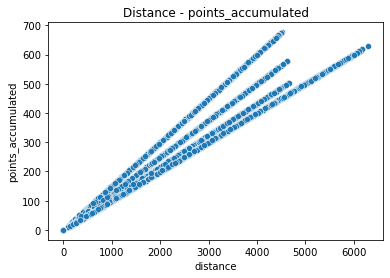

In [87]:

sns.scatterplot(x = 'distance', 
y = 'points_accumulated', 
data = df_2018)
plt.xlabel('distance')
plt.ylabel('points_accumulated')
plt.title("Distance - points_accumulated 2018");

Parar investigar más a fondo estas observaciones, en primer lugar, tomaré un registro unico sin criterio en la elección de la cantidad de puntos acumulados de cada cliente y realizaré una visualización, posteriormente crearé una función que tome solo el valor con mayor cantidad de números acumulados por  cliente en lugar de todos los registros. Esto nos permitirá visualizar si hay algún cambio significativo en la gráfica al considerar diferentes criterios. Es importante tener en cuenta que, si bien es posible que algunos clientes han consumido parte o la totalidad de sus puntos, intentaremos examinar cómo se comportan los datos bajo estas suposiciones. Otras categias pueden ser el tipo de ruta, clase de vuelo entre otras.

In [25]:
#  borramos los duplicados para el primer criterio
unique_customers_loyalty = df_2018.drop_duplicates(subset=['loyalty_number'])

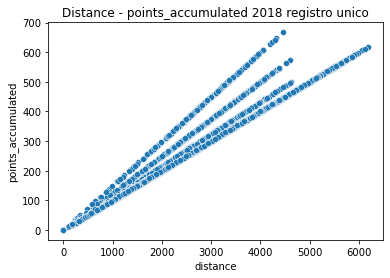

In [95]:
#  realizamos la grafica con el df que tiene un registro por cliente resultado de borrar los duplicados
sns.scatterplot(x = 'distance', 
y = 'points_accumulated', 
data = unique_customers_loyalty)
plt.xlabel('distance')
plt.ylabel('points_accumulated')
plt.title("Distance - points_accumulated 2018 registro unico");

In [64]:
def fil_max(df):
    """
    Esta función agrupa el DataFrame df por 'loyalty_number' y luego selecciona la fila con el mayor 
    valor de 'points_accumulated' dentro de cada grupo.
    
    Args:
    - df: DataFrame pandas que contiene las columnas 'loyalty_number' y 'points_accumulated'.
    
    Returns:
    - DataFrame pandas con una fila por cada 'loyalty_number', seleccionando la fila con el mayor 
    valor de 'points_accumulated' dentro de cada grupo.
    """
    # Agrupar por 'loyalty_number' y encontrar el índice correspondiente al máximo valor de 'points_accumulated' en cada grupo
    max_points_indices = df.groupby('loyalty_number')['points_accumulated'].idxmax()
    
    # Seleccionar las filas correspondientes a los índices encontrados
    result_df = df.loc[max_points_indices]
    
    return result_df

In [65]:
# aplicamos la funcion para obtener el valor unico de cliente que tiene mas puntos acumulados
df_max = fil_max(df)

In [66]:
# compruebo la cantidad de valores unicos 
n_u =df_max['loyalty_number'].unique()

print(f"cantidad de valores unicos:  {len(n_u)}")


cantidad de valores unicos:  16737


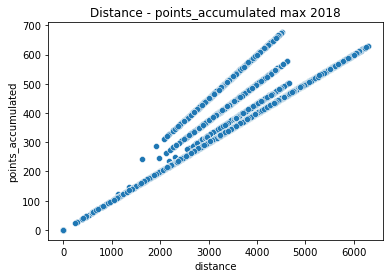

In [67]:
# Realizamos la grafica con cada cliente y el valor maximo de puntos acumulados
sns.scatterplot(x = 'distance', 
y = 'points_accumulated', 
data = df_max)
plt.xlabel('distance')
plt.ylabel('points_accumulated')
plt.title("Distance - points_accumulated max 2018");

De manera visual parece que esta condición no esta afectando el resultado. Como hemos dicho podemos utilizar otro tipo de pruebas para esta variable.

3. ¿Cuál es la distribución de los clientes por provincia o estado?

In [68]:
# Probamos otra manera de crear un dataframe con valores unicos loyalty_number  
n_u_l =df['loyalty_number'].unique()
print(f"cantidad de valores unicos id clientes:  {len(n_u_l)}")

cantidad de valores unicos id clientes:  16737


In [69]:
# Filtramos valores únicos de 'loyalty_number' y seleccionar la columna 'province', para ello borramos los duplicados
unique_customers_by_province = df.drop_duplicates(subset=['loyalty_number'])[['loyalty_number', 'province']]
unique_customers_by_province.shape

(16737, 2)

In [70]:
# Hacemos el groupby por 'province' y contamos el número de clientes únicos en cada provincia
customers_per_province = unique_customers_by_province.groupby('province').count()
df_customers_per_province = customers_per_province.reset_index()
df_customers_per_province

,province,loyalty_number
0,alberta,969
1,british_columbia,4409
2,manitoba,658
3,new_brunswick,636
4,newfoundland,258
5,nova_scotia,518
6,ontario,5404
7,prince_edward_island,66
8,quebec,3300
9,saskatchewan,409


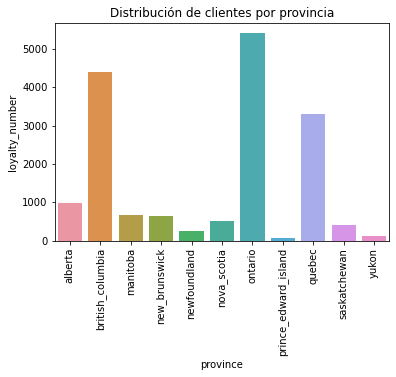

In [71]:
# Graficamos con un diagrama de barras en el eje x las provincias y en el eje y la frecuencia de los clientes. Rotamos el eje de los valores del eje x
sns.barplot(x='province', y='loyalty_number', data=df_customers_per_province)
plt.xticks(rotation = 90)
plt.title("Distribución de clientes por provincia");

Podemos observar que Ontario, British Columbia y Quebec son las provincias que presentan una mayor cantidad de clientes en comparación con el resto. Estas tres provincias destacan claramente por encima de las demás en términos de cantidad de clientes registrados. Por otro lado, las provincias de Prince Edward Island y Yukon muestran la menor cantidad de clientes. Esta disparidad en la cantidad de clientes entre las diferentes provincias podría ser el resultado de una variedad de factores, como por ejemplo la densidad de población, la actividad económica y la accesibilidad a los servicios de la compañía aérea en cada región. Estos hallazgos resaltan la importancia de considerar las diferencias regionales al desarrollar estrategias de marketing y planificación empresarial para la compañía aérea.

4. ¿Cómo se compara el salario promedio entre los diferentes niveles educativos de los clientes? Recordamos que la columna salary tiene nulos.Veamos su distribución


In [72]:
# revisamos los principales estadisticos
df["salary"].describe()

count    302952.000000
mean      79381.440228
std       34735.904533
min        9081.000000
25%       59262.000000
50%       73479.000000
75%       88612.000000
max      407228.000000
Name: salary, dtype: float64

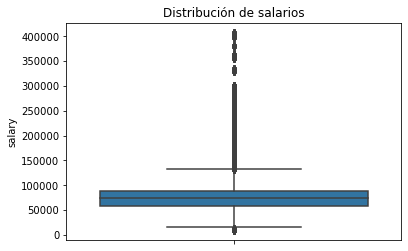

In [74]:
# Realizamos una primera visualización del comportamiento de los salarios.
sns.boxplot(y = 'salary',data = df)
plt.title("Distribución de salarios");

En este primer análisis, la presencia de valores atípicos en la gráfica de salarios es notable y esperable, ya que la distribución de los salarios puede variar significativamente entre y dentro de distintas categorías o grupos dentro del conjunto de datos. Además, la alta proporción de valores nulos en la columna de salarios puede influir en la distribución y en la identificación de estos valores atípicos. Por lo tanto, es crucial determinar cómo abordar los valores nulos antes de continuar con el análisis.

In [80]:
# Creamos un nuevo DataFrame con las filas donde 'salary' es nulo  y descubrimos que categorias tienen nulos.
df_nulos_salary = df[df['salary'].isnull()]
# Muestra las primeras filas del nuevo DataFrame
df_nulos_salary["education"].value_counts()

college    102672
Name: education, dtype: int64

In [79]:
# visualizamos el df creado
df_nulos_salary.head(5)

,loyalty_number,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
24,100102,ontario,toronto,m1r_4k3,male,college,NaN,single,nova,2887.74,standard,2013,3,uncancelled,uncancelled,2017,1,10,4,14,2030.0,203.0,0.0,0.0
25,100102,ontario,toronto,m1r_4k3,male,college,NaN,single,nova,2887.74,standard,2013,3,uncancelled,uncancelled,2017,2,0,0,0,0.0,0.0,0.0,0.0
26,100102,ontario,toronto,m1r_4k3,male,college,NaN,single,nova,2887.74,standard,2013,3,uncancelled,uncancelled,2017,4,9,0,9,648.0,64.0,0.0,0.0
27,100102,ontario,toronto,m1r_4k3,male,college,NaN,single,nova,2887.74,standard,2013,3,uncancelled,uncancelled,2017,5,0,0,0,0.0,0.0,0.0,0.0
28,100102,ontario,toronto,m1r_4k3,male,college,NaN,single,nova,2887.74,standard,2013,3,uncancelled,uncancelled,2017,6,0,0,0,0.0,0.0,0.0,0.0


Nuestra base de datos incluye las categorías high_school_or_below, bachelor, master, college y doctor dentro de la variable educación. Es llamativo que la categoría college concentre el total de los valores nulos y no cuente con ningún valor. Dado que estamos llevando a cabo nuestro análisis en Canadá, investigué los niveles educativos específicos en este país para obtener una comprensión más clara de los datos.

High School representa la educación básica, seguida por el college, que ofrece programas de educación postsecundaria más prácticos y orientados al empleo. Los programas de bachelor en universidades proporcionan una educación más amplia y académica en un campo específico, y conducen a la obtención de un título de licenciatura. Los títulos más altos son master y doctorado.

En principio, informandome en paginas de la economía de Canadá, entiendo que los salarios de college se acercan más a los de high school, pero para confirmarlo con más detalle, podríamos obtener información adicional de diversas fuentes, como estadísticas gubernamentales, informes de la industria o encuestas salariales. Esto podría proporcionar una visión más detallada de la distribución de los salarios para la categoría educativa de college en particular. Sin embargo, este proceso podría llevar más tiempo.

Por otra parte observamos una diferencia porcentual en nuestra base de datos entre los salarios de high school, y los de bachelor.

Tenemos varias opciones para manejar los valores nulos en la categoría de college. Podríamos basarnos en estadísticas disponibles como el caso de las gubernamentales; establecer una media ponderada entre high school y bachelor, o utilizar métodos como KNN (vecinos más cercanos).

En principio realizaré el analisis sin esta columna, intentaré hablar primero con la empresa por si existe algun tipo de información sobre este colectivo y en caso de no existir le daría la posibilidad de estimar estos valores mediante los metodos de imputación mas avanzados.

In [77]:
# Filtrar las filas donde 'salary' no es nulo y además 
df_no_nulos_salary = df[df['salary'].notnull()]

# Mostrar las primeras filas del nuevo DataFrame
df_no_nulos_salary.shape

(302952, 24)

In [81]:
# visualizamos los principales estadisticos
df_no_nulos_salary.describe()

,loyalty_number,salary,clv,enrollment_year,enrollment_month,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
count,302952.000000,302952.000000,302952.000000,302952.000000,302952.000000,302952.000000,302952.000000,302952.000000,302952.000000,302952.000000,302952.000000,302952.000000,302952.000000,302952.000000
mean,550214.781827,79381.440228,8133.139523,2015.246534,6.668621,2017.500000,6.500000,4.102188,1.027546,5.129733,1206.698319,123.510918,30.493656,2.468031
std,260155.279979,34735.904533,6962.273365,1.985110,3.387973,0.500001,3.452058,5.219821,2.072329,6.512395,1433.422843,146.673943,125.056324,10.115195
min,100018.000000,9081.000000,2119.890000,2012.000000,1.000000,2017.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,325802.000000,59262.000000,4089.460000,2014.000000,4.000000,2017.000000,3.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,551533.000000,73479.000000,5810.630000,2015.000000,7.000000,2017.500000,6.500000,1.000000,0.000000,1.000000,472.000000,48.000000,0.000000,0.000000
75%,773943.000000,88612.000000,9075.770000,2017.000000,10.000000,2018.000000,9.250000,8.000000,1.000000,10.000000,2332.000000,239.000000,0.000000,0.000000
max,999986.000000,407228.000000,83325.380000,2018.000000,12.000000,2018.000000,12.000000,21.000000,11.000000,32.000000,6293.000000,676.500000,876.000000,71.000000


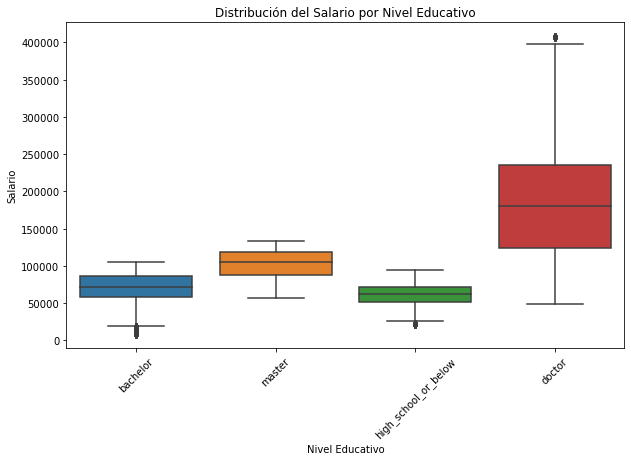

In [82]:

# Creamos un gráfico de boxplot para visualizar la distribución del salario por nivel educativo
plt.figure(figsize=(10, 6))
sns.boxplot(x='education', y='salary', data=df_no_nulos_salary)
plt.xlabel('Nivel Educativo')
plt.ylabel('Salario')
plt.title('Distribución del Salario por Nivel Educativo')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mayor legibilidad
plt.show()


Los datos muestran una tendencia de aumento en los rangos salariales conforme aumenta el nivel educativo , en general se observan outliers lo que finalmente afecta la desviación en los estadisticos.

In [83]:
# Calcular el salario promedio por nivel educativo y los ordenamos de forma ascendente
salary_mean_educacion = df_no_nulos_salary.groupby('education')['salary'].mean().reset_index()
salary_mean_educacion.sort_values(by='salary', ascending=True)

,education,salary
2,high_school_or_below,61112.377525
0,bachelor,72601.235033
3,master,103767.494163
1,doctor,178335.439516


In [84]:
# revisamos los principales estadisticos de los salarios sin nulos
salary_mean_education = df_no_nulos_salary.groupby('education')['salary'].describe()
salary_mean_education

,count,mean,std,min,25%,50%,75%,max
education,,,,,,,,
bachelor,253752.0,72601.235033,16670.286198,9081.0,58711.00,71971.0,85848.00,105563.0
doctor,17856.0,178335.439516,70307.642502,48109.0,124343.75,180440.0,235069.25,407228.0
high_school_or_below,19008.0,61112.377525,12105.086402,21853.0,52044.75,61806.0,71344.00,93875.0
master,12336.0,103767.494163,17514.343573,56414.0,88120.00,105487.0,118530.00,133080.0


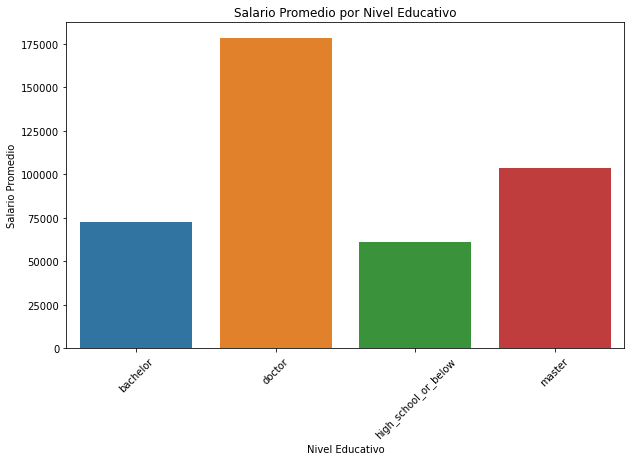

In [85]:
# Calcular el salario promedio por nivel educativo
salary_mean_education1 = df_no_nulos_salary.groupby('education')['salary'].mean().reset_index()

# Crear un gráfico de barras para comparar el salario promedio entre los diferentes niveles educativos
plt.figure(figsize=(10, 6))
sns.barplot(x='education', y='salary', data=salary_mean_education1)
plt.xlabel('Nivel Educativo')
plt.ylabel('Salario Promedio')
plt.title('Salario Promedio por Nivel Educativo')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mayor legibilidad
plt.show()

Observamos los salarios mas altos en los niveles educativos de doctor y master. En cuanto al salario de college podemos investigar con mas detalle con estadisticos de Canada, como hemos dicho los salarios de college probablemente sean  mas parecidos a los de hight school , sin embargo intervienen tambien otros factores como el sector y la experiencia lo cual esta reflejado en los rangos que existen entre los salarios. En este momento no cuento con una muestra de estos salarios con lo que tendria que hacer una investigación adicional.Puedo hacerlo con mas detalle y mas cercana a la realidad pero es una investigación que requiere mas tiempo desarrollarla. De todas formas realizaremos una imputación que permita trabajar con esta categoria. Aplicaremos los metodos IterativeImputer y kNNImputer y luego compararemos resultados

In [87]:
df_copy = df.copy()
df_copy.head(1)

,loyalty_number,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
0,100018,alberta,edmonton,t9g_1w3,female,bachelor,92552.0,married,aurora,7919.2,standard,2016,8,uncancelled,uncancelled,2017,1,3,0,3,1521.0,152.0,0.0,0.0


In [88]:
# aplicaremos los dos métodos para luego compararlos, empezaremos por el IterativeImputer
# instanciamos las clases
imputer_iterative = IterativeImputer(max_iter = 20, random_state = 42)

# ajustamos y tranformamos los datos
imputer_iterative_imput = imputer_iterative.fit_transform(df_copy[["salary"]])

# comprobamos que es lo que nos devuelve, que en este caso es un array también
print(imputer_iterative_imput)

[[92552.]
 [92552.]
 [92552.]
 ...
 [46594.]
 [46594.]
 [46594.]]


In [89]:
# en este caso como vamos a aplicar los dos métodos sobre estas columnas vamos a crear una  columna nueva
df_copy[["salary_iterative"]] = imputer_iterative_imput

# comprobamos los nulos
print(f"Después del 'Iterative' tenemos: \n{df_copy[['salary_iterative']].isnull().sum()} nulos")

Después del 'Iterative' tenemos: 
salary_iterative    0
dtype: int64 nulos


In [ ]:
# hagamos ahora lo mismo con el KNNImputer. Dejamos señalada la forma de aplicarlo debido a que hemos tenido inconvenientes para ejecutarlo

# instanciamos la clase del KNNImputer
imputer_knn = KNNImputer(n_neighbors = 20)

# ajustamos y transformamos los datos
imputer_knn_imput = imputer_knn.fit_transform(df_copy[["salary"]])

# comprobamos que es lo que nos devuelve, que sigue siendo un array
imputer_knn_imput

In [ ]:
# por último nos queda añadir ese array al DataFrame como hemos hecho hasta ahora
df_copy[["salary_knn"]] = imputer_knn_imput


# comprobamos los nulos
print(f"Después del 'KNN' tenemos: \n{df_copy[['salary_knn']].isnull().sum()} nulos")

In [90]:
df_copy.describe()[["salary","salary_iterative"]]

,salary,salary_iterative
count,302952.000000,405624.000000
mean,79381.440228,79381.440228
std,34735.904533,30019.504623
min,9081.000000,9081.000000
25%,59262.000000,63899.000000
50%,73479.000000,79381.440228
75%,88612.000000,82940.000000
max,407228.000000,407228.000000


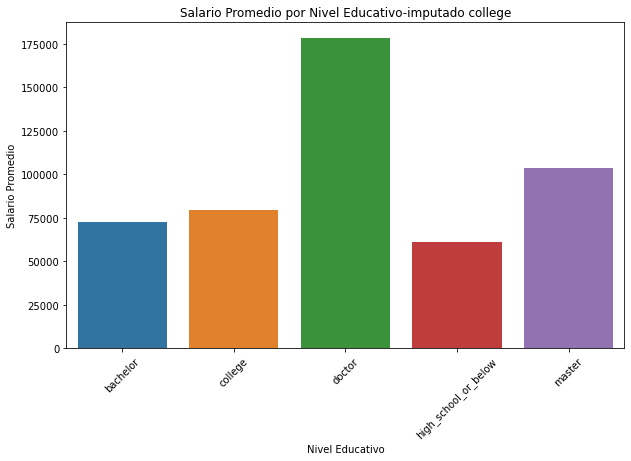

In [91]:
# Calcular el salario promedio por nivel educativo
salary_mean = df_copy.groupby('education')['salary_iterative'].mean().reset_index()

# Crear un gráfico de barras para comparar el salario promedio entre los diferentes niveles educativos
plt.figure(figsize=(10, 6))
sns.barplot(x='education', y='salary_iterative', data=salary_mean)
plt.xlabel('Nivel Educativo')
plt.ylabel('Salario Promedio')
plt.title('Salario Promedio por Nivel Educativo-imputado college')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mayor legibilidad
plt.show()

Esta imputación me arroja resultados que entiendo estan alejados de la realidad, los salarios de college deberian estar entre los salarios de hig scholl y bachellor. Una alternativa sería asignar medias ponderadas y le daria mas peso a los salarios de high school que a los salarios de bachiller. Por otra parte los salarios de college estan entre high school y bachiller con lo que quizas seria mas interesante realizar el interactive teniendo encuenta estas dos categorias.

In [92]:
df_filtrado = pd.DataFrame(df[df['education'].isin(['bachelor', "college", 'high_school_or_below'])])

In [93]:
df_filtrado["education"].value_counts()

bachelor                253752
college                 102672
high_school_or_below     19008
Name: education, dtype: int64

In [94]:
# aplicaremos los dos métodos para luego compararlos, empezaremos por el IterativeImputer
# instanciamos las clases
imputer_iterative1 = IterativeImputer(max_iter = 20, random_state = 42)

# ajustamos y tranformamos los datos
imputer_iterative_imput1 = imputer_iterative1.fit_transform(df_filtrado[["salary"]])

# comprobamos que es lo que nos devuelve, que en este caso es un array también
print(imputer_iterative_imput1)

[[92552.]
 [92552.]
 [92552.]
 ...
 [46594.]
 [46594.]
 [46594.]]


In [95]:
# en este caso como vamos a aplicar los dos métodos sobre estas columnas vamos a crear una  columna nueva
df_filtrado[["salary_iterative"]] = imputer_iterative_imput1

# comprobamos los nulos
print(f"Después del 'Iterative' tenemos: \n{df_filtrado[['salary_iterative']].isnull().sum()} nulos")


Después del 'Iterative' tenemos: 
salary_iterative    0
dtype: int64 nulos


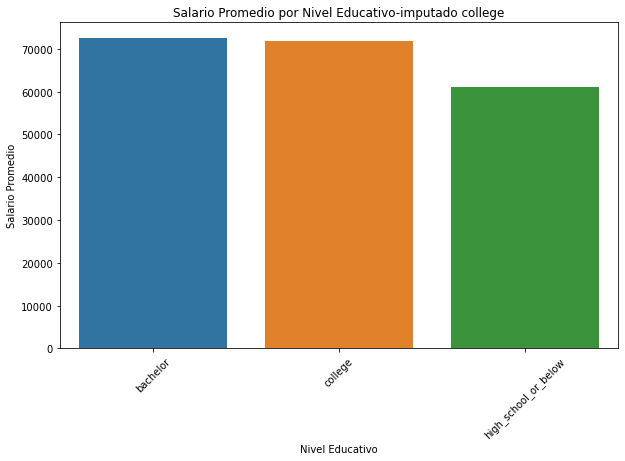

In [96]:
# Calcular el salario promedio por nivel educativo
salary_mean = df_filtrado.groupby('education')['salary_iterative'].mean().reset_index()

# Crear un gráfico de barras para comparar el salario promedio entre los diferentes niveles educativos
plt.figure(figsize=(10, 6))
sns.barplot(x='education', y='salary_iterative', data=salary_mean)
plt.xlabel('Nivel Educativo')
plt.ylabel('Salario Promedio')
plt.title('Salario Promedio por Nivel Educativo-imputado college')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mayor legibilidad
plt.show()

Con esta teoria sigue acercandose mas a los valores de bachellor, por lo que sugeriria  probar el kNNi imputer.

5. ¿Cuál es la proporción de clientes con diferentes tipos de tarjetas de fidelidad?

In [97]:
#agrupamos por el tipo de tarjeta y luego contamos las que hay en cada categoria
df_proporcion = df_max.groupby('loyalty_card')["loyalty_number"].count().reset_index()

In [98]:
df_proporcion

,loyalty_card,loyalty_number
0,aurora,3429
1,nova,5671
2,star,7637


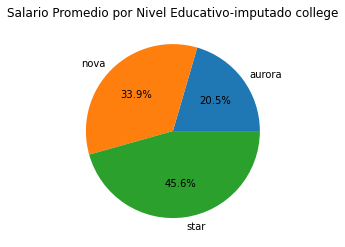

In [99]:
plt.pie("loyalty_number", labels= "loyalty_card",data = df_proporcion, autopct=  '%1.1f%%')
plt.title('Salario Promedio por Nivel Educativo-imputado college');


La tarjeta de fidelidad Star es la más popular entre los clientes, siendo utilizada por el 45% de ellos, seguida de cerca por la tarjeta Nova con el 33.9% de los clientes. Por ultimo latarjeta Aurora, con un 20.5%  es la opción menos común entre los clientes.

6. ¿Cómo se distribuyen los clientes según su estado civil y género

In [101]:
# Crear una tabla de contingencia
tabla_contingencia = pd.crosstab(df_max['marital_status'], df_max['gender'])
# Mostrar la tabla de contingencia
tabla_contingencia

gender,female,male
marital_status,,
divorced,1269,1249
married,4869,4866
single,2272,2212


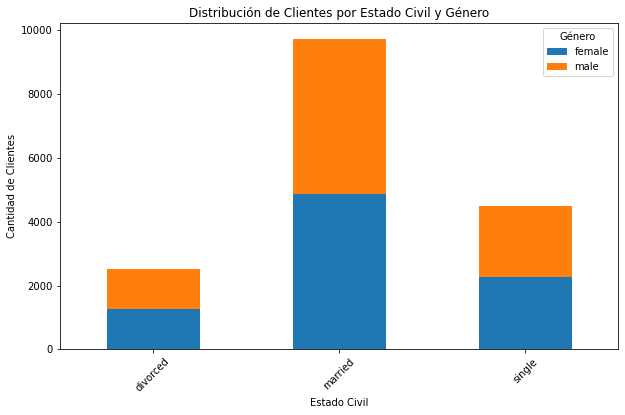

In [53]:
# Crear un gráfico de barras apiladas
tabla_contingencia.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configurar el título y etiquetas de los ejes
plt.title('Distribución de Clientes por Estado Civil y Género')
plt.xlabel('Estado Civil')
plt.ylabel('Cantidad de Clientes')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mayor legibilidad

# Mostrar el gráfico
plt.legend(title='Género')

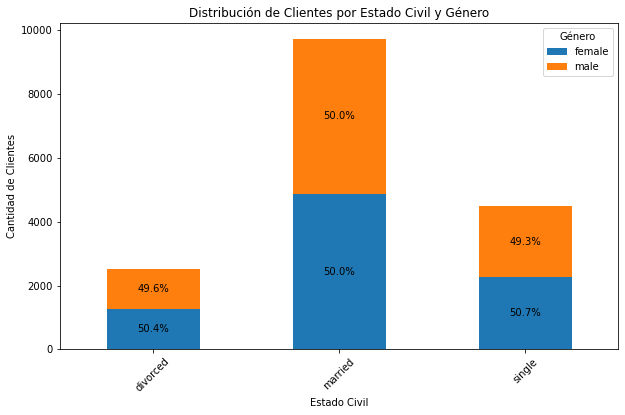

In [54]:

# Crear un gráfico de barras apiladas
ax = tabla_contingencia.plot(kind='bar', stacked=True, figsize=(10, 6))

# Obtener el total de clientes por categoría de estado civil
totals = tabla_contingencia.sum(axis=1)

# Agregar los porcentajes dentro de cada barra
for bar in ax.containers:
    ax.bar_label(bar, labels=[f"{h/total*100:.1f}%" for h, total in zip(bar.datavalues, totals)], label_type='center')

# Configurar el título y etiquetas de los ejes
plt.title('Distribución de Clientes por Estado Civil y Género')
plt.xlabel('Estado Civil')
plt.ylabel('Cantidad de Clientes')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mayor legibilidad

# Mostrar el gráfico
plt.legend(title='Género')
plt.show()


La distribución de tarjetas por género del cliente está equilibrada, con aproximadamente un 50% en cada categoría de género.

Fase 3: Evaluación de Diferencias en Reservas de Vuelos por Nivel Educativo
Objetivo del Ejercicio: Utilizando un conjunto de datos que hemos compartido, se busca evaluar si existen diferencias significativas en el número de vuelos
reservados según el nivel educativo de los clientes. Para ello, los pasos que deberas seguir son:


1. Preparación de Datos:
Filtra el conjunto de datos para incluir únicamente las columnas relevantes: 'Flights Booked' y 'Education'.

In [102]:
df_flights_education = df[['flights_booked', 'education']]
df_flights_education

,flights_booked,education
0,3,bachelor
1,2,bachelor
2,6,bachelor
3,4,bachelor
4,0,bachelor
...,...,...
405619,15,bachelor
405620,0,bachelor
405621,6,bachelor
405622,11,bachelor


2. Análisis Descriptivo:
Agrupa los datos por nivel educativo y calcula estadísticas descriptivas básicas (como el promedio, la desviación estandar, los percentiles) del número de vuelos reservados para cada grupo.

In [103]:
#visualizamos realizando un grafico.
df_pie = df.groupby('education')["flights_booked"].count().reset_index()

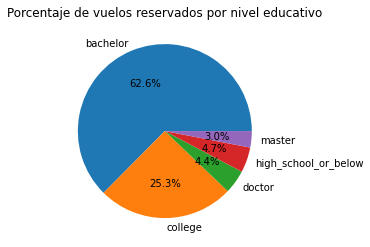

In [104]:
plt.pie("flights_booked", labels= "education",data = df_pie, autopct=  '%1.1f%%')
plt.title('Porcentaje de vuelos reservados por nivel educativo');

In [76]:
#visualizamos los estadisticos del conjunto
df_e_f = df_flights_education.groupby("education")['flights_booked'].describe()
df_e_f.reset_index()

,education,count,mean,std,min,25%,50%,75%,max
0,bachelor,252567.0,4.110288,5.221671,0.0,0.0,1.0,8.0,21.0
1,college,102260.0,4.169744,5.246040,0.0,0.0,1.0,8.0,21.0
2,doctor,17731.0,4.175512,5.256971,0.0,0.0,1.0,8.0,21.0
3,high_school_or_below,18915.0,4.176209,5.239267,0.0,0.0,1.0,8.0,21.0
4,master,12287.0,4.200700,5.213956,0.0,0.0,1.0,8.0,21.0


Para todos los niveles educativos se presentan resultados similares en sus estadisticas descriptivas,el 88% de los vuelos son reservados por personas con nivel educativo bachelor y college

3. Prueba Estadística:
Realiza una prueba de A/B testing para determinar si existe una diferencia significativa en el número de vuelos reservados entre los diferentes
niveles educativos.

Creamos dos grupos de nivel de estudios para plantear nuestras hipotesis:
Secondary_College = ["high_school_or_below", "College"]
advanced_education = ["bachelor","doctor", "master"]

Hipótesis nula (H0): No hay diferencia significativa e entre los vuelos de los grupos de educación basica y avanzada  "Secondary_College" y "advanced_education".

Hipótesis alternativa (H1): Existe una diferencia significativa entre los vuelos de los grupos de educación basica y avanzada  "Secondary_College" y "advanced_education".


In [80]:
# una vez que tengamos nuestro DataFrame preparado con todas las columnas que queremos vamos a crear una función que no haga una exploración inicial del conjunto de datos
def exploracion_dataframe(dataframe, columna_control):
    """
    Realiza un análisis exploratorio básico de un DataFrame, mostrando información sobre duplicados,
    valores nulos, tipos de datos, valores únicos para columnas categóricas y estadísticas descriptivas
    para columnas categóricas y numéricas, agrupadas por la columna de control.

    Parámetros:
    - dataframe (DataFrame): El DataFrame que se va a explorar.
    - columna_control (str): El nombre de la columna que se utilizará como control para dividir el DataFrame.

    Returns: 
    No devuelve nada directamente, pero imprime en la consola la información exploratoria.
    """
    
    print(f"Los duplicados que tenemos en el conjunto de datos son: {dataframe.duplicated().sum()}")
    print("\n ..................... \n")
    
    
    # generamos un DataFrame para los valores nulos
    print("Los nulos que tenemos en el conjunto de datos son:")
    df_nulos = pd.DataFrame(dataframe.isnull().sum() / dataframe.shape[0] * 100, columns = ["%_nulos"])
    display(df_nulos[df_nulos["%_nulos"] > 0])
    
    print("\n ..................... \n")
    print(f"Los tipos de las columnas son:")
    display(pd.DataFrame(dataframe.dtypes, columns = ["tipo_dato"]))
    
    
    print("\n ..................... \n")
    print("Los valores que tenemos para las columnas categóricas son: ")
    dataframe_categoricas = dataframe.select_dtypes(include = "O")
    
    for col in dataframe_categoricas.columns:
        print(f"La columna {col.upper()} tiene las siguientes valore únicos:")
        display(pd.DataFrame(dataframe[col].value_counts()).head())    
    
    # como estamos en un problema de A/B testing y lo que realmente nos importa es comparar entre el grupo de control y el de test, los principales estadísticos los vamos a sacar de cada una de las categorías
    
    for categoria in dataframe[columna_control].unique():
        
        dataframe_filtrado = dataframe[dataframe[columna_control] == categoria]
    
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas categóricas para el {categoria.upper()} son: ")
        display(dataframe_filtrado.describe(include = "O").T)
        
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas numéricas para el {categoria.upper()} son: ")
        display(dataframe_filtrado.describe().T)

Aunque hemos filtrado el dataframe para trabajar con las dos columnas, utilizaré el dataframe df ya que las columnas para el estudio son indiferentes de los ultimos cambios que hemos realizado, exploramos con los principales estadisticos incluyendo  la columna de control que en este caso es educacion.

In [86]:
# llamamos a la función de exploración
exploracion_dataframe(df, "education")

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos
salary,25.326927
cancellation_year,87.703091
cancellation_month,87.703091



 ..................... 

Los tipos de las columnas son:


,tipo_dato
loyalty_number,int64
province,object
city,object
postal_code,object
gender,object
education,object
salary,float64
marital_status,object
loyalty_card,object
clv,float64



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna PROVINCE tiene las siguientes valore únicos:


,province
ontario,130258
british_columbia,106442
quebec,79573
alberta,23360
manitoba,15900


La columna CITY tiene las siguientes valore únicos:


,city
toronto,80775
vancouver,62314
montreal,49687
winnipeg,15900
whistler,13994


La columna POSTAL_CODE tiene las siguientes valore únicos:


,postal_code
v6e_3d9,21944
v5r_1w3,16529
v6t_1y8,13994
v6e_3z3,13128
m2m_7k8,12855


La columna GENDER tiene las siguientes valore únicos:


,gender
female,202757
male,201003


La columna EDUCATION tiene las siguientes valore únicos:


,education
bachelor,252567
college,102260
high_school_or_below,18915
doctor,17731
master,12287


La columna MARITAL_STATUS tiene las siguientes valore únicos:


,marital_status
married,234845
single,108153
divorced,60762


La columna LOYALTY_CARD tiene las siguientes valore únicos:


,loyalty_card
star,183745
nova,136883
aurora,83132


La columna ENROLLMENT_TYPE tiene las siguientes valore únicos:


,enrollment_type
standard,380419
2018_promotion,23341



 ..................... 

Los principales estadísticos de las columnas categóricas para el BACHELOR son: 


,count,unique,top,freq
province,252567,11,ontario,80817
city,252567,29,toronto,50931
postal_code,252567,54,v6e_3d9,13906
gender,252567,2,female,127302
education,252567,1,bachelor,252567
marital_status,252567,3,married,171506
loyalty_card,252567,3,star,108148
enrollment_type,252567,2,standard,237369



 ..................... 

Los principales estadísticos de las columnas numéricas para el BACHELOR son: 


,count,mean,std,min,25%,50%,75%,max
loyalty_number,252567.0,548114.325134,260447.229088,100018.00,323011.50,548037.00,772484.00,999986.00
salary,252567.0,72599.080913,16667.675569,9081.00,58711.00,71972.00,85866.00,105563.00
clv,252567.0,8211.231866,7058.364835,2255.31,4142.56,5866.42,9080.64,83325.38
enrollment_year,252567.0,2015.261016,1.989055,2012.00,2014.00,2015.00,2017.00,2018.00
enrollment_month,252567.0,6.647032,3.380208,1.00,4.00,7.00,10.00,12.00
cancellation_year,30899.0,2016.487621,1.385779,2013.00,2016.00,2017.00,2018.00,2018.00
cancellation_month,30899.0,7.049969,3.464143,1.00,4.00,7.00,10.00,12.00
year,252567.0,2017.500370,0.500001,2017.00,2017.00,2018.00,2018.00,2018.00
month,252567.0,6.501043,3.451966,1.00,4.00,7.00,10.00,12.00
flights_booked,252567.0,4.110288,5.221671,0.00,0.00,1.00,8.00,21.00



 ..................... 

Los principales estadísticos de las columnas categóricas para el COLLEGE son: 


,count,unique,top,freq
province,102260,11,ontario,33480
city,102260,29,toronto,20224
postal_code,102260,55,v6e_3d9,5734
gender,102260,2,male,51898
education,102260,1,college,102260
marital_status,102260,3,single,58527
loyalty_card,102260,3,star,50863
enrollment_type,102260,2,standard,96541



 ..................... 

Los principales estadísticos de las columnas numéricas para el COLLEGE son: 


,count,mean,std,min,25%,50%,75%,max
loyalty_number,102260.0,549280.619010,255249.759603,100102.00,330053.00,547699.00,764980.00,999982.00
salary,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clv,102260.0,7584.627706,6555.084078,1898.01,3747.06,5568.95,8500.12,74228.52
enrollment_year,102260.0,2015.266781,1.962211,2012.00,2014.00,2015.00,2017.00,2018.00
enrollment_month,102260.0,6.668072,3.436317,1.00,4.00,7.00,10.00,12.00
cancellation_year,12655.0,2016.571948,1.367285,2013.00,2016.00,2017.00,2018.00,2018.00
cancellation_month,12655.0,6.888582,3.331803,1.00,4.00,7.00,10.00,12.00
year,102260.0,2017.500196,0.500002,2017.00,2017.00,2018.00,2018.00,2018.00
month,102260.0,6.501242,3.452016,1.00,4.00,7.00,10.00,12.00
flights_booked,102260.0,4.169744,5.246040,0.00,0.00,1.00,8.00,21.00



 ..................... 

Los principales estadísticos de las columnas categóricas para el MASTER son: 


,count,unique,top,freq
province,12287,11,ontario,4108
city,12287,29,toronto,2476
postal_code,12287,53,v6e_3d9,672
gender,12287,2,female,6432
education,12287,1,master,12287
marital_status,12287,3,married,5035
loyalty_card,12287,3,star,6692
enrollment_type,12287,2,standard,11831



 ..................... 

Los principales estadísticos de las columnas numéricas para el MASTER son: 


,count,mean,std,min,25%,50%,75%,max
loyalty_number,12287.0,549248.162448,264145.849788,100644.00,316746.50,549064.00,781463.00,998072.00
salary,12287.0,103734.523724,17518.492270,56414.00,88120.00,105487.00,118530.00,133080.00
clv,12287.0,7494.386544,5903.160539,2174.11,3600.93,5140.39,10083.49,30591.61
enrollment_year,12287.0,2015.238056,1.944088,2012.00,2014.00,2015.00,2017.00,2018.00
enrollment_month,12287.0,6.821681,3.388708,1.00,4.00,7.00,10.00,12.00
cancellation_year,1560.0,2016.723077,1.353581,2013.00,2016.00,2017.00,2018.00,2018.00
cancellation_month,1560.0,6.338462,3.652417,1.00,3.00,7.00,10.00,12.00
year,12287.0,2017.500692,0.500020,2017.00,2017.00,2018.00,2018.00,2018.00
month,12287.0,6.502157,3.452259,1.00,4.00,7.00,10.00,12.00
flights_booked,12287.0,4.200700,5.213956,0.00,0.00,1.00,8.00,21.00



 ..................... 

Los principales estadísticos de las columnas categóricas para el HIGH_SCHOOL_OR_BELOW son: 


,count,unique,top,freq
province,18915,11,ontario,6233
city,18915,29,toronto,3835
postal_code,18915,54,v5r_1w3,910
gender,18915,2,female,9696
education,18915,1,high_school_or_below,18915
marital_status,18915,3,married,12505
loyalty_card,18915,3,star,9620
enrollment_type,18915,2,standard,17715



 ..................... 

Los principales estadísticos de las columnas numéricas para el HIGH_SCHOOL_OR_BELOW son: 


,count,mean,std,min,25%,50%,75%,max
loyalty_number,18915.0,557841.598784,258899.087562,101148.00,331325.00,561092.0,782804.00,994541.0
salary,18915.0,61146.378165,12105.350590,21853.00,52054.00,61806.0,71344.00,93875.0
clv,18915.0,7731.270379,6658.365908,2272.34,3707.28,5274.2,8991.98,43290.5
enrollment_year,18915.0,2015.197145,1.982687,2012.00,2014.00,2015.0,2017.00,2018.0
enrollment_month,18915.0,6.613904,3.451742,1.00,4.00,7.0,10.00,12.0
cancellation_year,2232.0,2016.301075,1.382103,2013.00,2015.00,2017.0,2017.00,2018.0
cancellation_month,2232.0,6.559140,3.755301,1.00,3.00,7.0,10.00,12.0
year,18915.0,2017.500502,0.500013,2017.00,2017.00,2018.0,2018.00,2018.0
month,18915.0,6.503569,3.452150,1.00,4.00,7.0,10.00,12.0
flights_booked,18915.0,4.176209,5.239267,0.00,0.00,1.0,8.00,21.0



 ..................... 

Los principales estadísticos de las columnas categóricas para el DOCTOR son: 


,count,unique,top,freq
province,17731,11,ontario,5620
city,17731,29,toronto,3309
postal_code,17731,55,v6e_3z3,867
gender,17731,2,female,8965
education,17731,1,doctor,17731
marital_status,17731,3,married,11174
loyalty_card,17731,3,star,8422
enrollment_type,17731,2,standard,16963



 ..................... 

Los principales estadísticos de las columnas numéricas para el DOCTOR son: 


,count,mean,std,min,25%,50%,75%,max
loyalty_number,17731.0,570327.226834,254389.869544,101594.00,355994.00,581380.00,788292.00,999911.00
salary,17731.0,178403.675202,70380.054033,48109.00,124407.00,180440.00,236612.00,407228.00
clv,17731.0,7815.738556,6467.049620,2119.89,4046.94,5623.31,8583.27,58207.13
enrollment_year,17731.0,2015.077266,1.952483,2012.00,2013.00,2015.00,2017.00,2018.00
enrollment_month,17731.0,6.907337,3.384204,1.00,4.00,7.00,10.00,12.00
cancellation_year,2304.0,2016.406250,1.358742,2013.00,2015.00,2016.50,2018.00,2018.00
cancellation_month,2304.0,7.000000,3.464854,1.00,4.00,7.00,10.00,12.00
year,17731.0,2017.500592,0.500014,2017.00,2017.00,2018.00,2018.00,2018.00
month,17731.0,6.503074,3.452037,1.00,4.00,7.00,10.00,12.00
flights_booked,17731.0,4.175512,5.256971,0.00,0.00,1.00,8.00,21.00


In [105]:
# Seleccionamos todas las filas del DataFrame education donde el valor en la columna "education" sea "high_school_or_below" y "college
df_secondary_college_education = df[df["education"].isin(["high_school_or_below", "college"])]
df_secondary_college_education.shape


(121680, 24)

In [106]:
df_secondary_college_education["education"].value_counts()

college                 102672
high_school_or_below     19008
Name: education, dtype: int64

In [107]:
# Seleccionamos todas las filas del DataFrame education donde el valor en la columna "education" sea "bachelor","doctor" y "master"
df_advanced_education = df[df["education"].isin(["bachelor","doctor", "master"])]
df_advanced_education.shape

(283944, 24)

In [108]:
df_advanced_education["education"].value_counts()

bachelor    253752
doctor       17856
master       12336
Name: education, dtype: int64

In [109]:
# calculamos el valor de las medias para cada grupo
s_c_mean =df_secondary_college_education['flights_booked'].mean()
a_e_mean = df_advanced_education['flights_booked'].mean()

print(f"Media de vuelos en educación secundaria y college: {s_c_mean}")
print(f"Media de vuelos en educacion avanzada : {a_e_mean}")

Media de vuelos en educación secundaria y college: 4.15344345825115
Media de vuelos en educacion avanzada : 4.098600428253459


In [110]:
# creamos una nueva columna "control" y le asignamos el valor con el cual vamos a comparar
df_secondary_college_education["control"] = "secondary_college"
df_advanced_education["control"] = "advanced_education"

In [111]:
df_secondary_college_education["control"].unique()

array(['secondary_college'], dtype=object)

In [112]:
df_advanced_education["control"].unique()

array(['advanced_education'], dtype=object)

In [113]:
#unimos los grupos creados
df_control = pd.concat([df_secondary_college_education, df_advanced_education], ignore_index=True)
df_control.shape

(405624, 25)

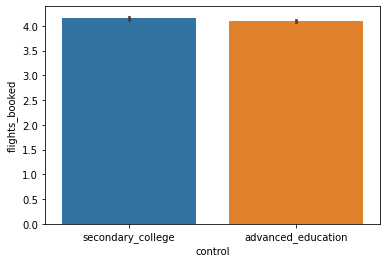

In [114]:
#graficamos para visualizar el comportamiento de cada categoria
sns.barplot(data = df_control, y = "flights_booked", x = "control");

In [115]:
# evaluamos homogeneidad con la prueba de shapiro
_,p_value = shapiro(df_control["flights_booked"])
print(f"p-Value: {p_value}")

p-Value: 0.0


Debe cumplir lo siguiente :
- H0: Datos normales
- H1: NO normales

p_value < 0.05 rechazamos H0 --> datos no son normales asi que continuamos con otro metodo

Continuamos con la prueba de mannwhitneyu debido a que los datos no son normales.
Para esta prueba Si el valor p (p-value) es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en la cantidad promedio de vuelos reservados  entre los grupos.

Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa entre los vuelos de los grupos de educación basica y avanzada  "Secondary_College" y "advanced_education".

In [116]:
#utilizamos la prueba alternativa mannwhitneyu cuando los datos no son homogeneos
statistic, p_value = mannwhitneyu(df_secondary_college_education["flights_booked"], df_advanced_education["flights_booked"])

# Imprimir los resultados
print("Estadístico de la prueba de Mann-Whitney U:", statistic)
print("Valor p:", p_value)

Estadístico de la prueba de Mann-Whitney U: 17376098893.5
Valor p: 0.0016709911534266038


Debido a que p_value < 0.05 rechazamos H0

Es decir hay suficiente evidencia para afirmar que hay una diferencia significativa entre los vuelos de los grupos de educación basica y avanzada  "Secondary_College" y "advanced_education". 

In [113]:
df.to_csv('df_clean.csv', index=False)


Imputar los salarios de college, se puede utilizar información estadistica del pais, y realizar la prueba estadistica que no ha podido ser utilizada.
La gran mayoria de columnas no tienen nulos, esto es positivo ya que contamos con mucha información valiosa para la toma de decisiones.